In [1]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image, ImageFilter

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import models, transforms
from torchvision.datasets import ImageFolder
from torchvision.models import ResNet18_Weights

In [2]:
class Load_data(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_files = [f for f in os.listdir(root_dir) if f.endswith(('.TIF'))]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.image_files[idx])
        image = Image.open(img_path)
        if self.transform:
            image = self.transform(image)
        return image

In [3]:
class Preprocess:
    def __call__(self, image):
        sample = np.array(image)
        sample = cv2.normalize(sample, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
        processed_image = Image.fromarray(sample).convert('RGB')
        return processed_image

In [4]:
train_transform = transforms.Compose([
    Preprocess(),
    transforms.Resize((1024, 1024)),
    transforms.RandomRotation(degrees=(-30, 30)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    Preprocess(),
    transforms.Resize((1024, 1024)),
    transforms.ToTensor()
])

# Load full dataset
full_dataset = Load_data(root_dir='images/normal', transform=transforms.Compose([
    Preprocess(),
    transforms.Resize((1024, 1024)),
    transforms.ToTensor()
]))

# Train/Test Split
train_size = 9
test_size = 2
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

# Assign separate transforms
train_dataset.dataset.transform = train_transform
test_dataset.dataset.transform = test_transform

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

# Check sizes
print(f"Train Dataset Size: {len(train_dataset)}")
print(f"Test Dataset Size: {len(test_dataset)}")

Train Dataset Size: 9
Test Dataset Size: 2


In [5]:
pretrained_encoder = models.vgg16(weights="IMAGENET1K_V1")
encoder = nn.Sequential(*list(pretrained_encoder.features.children())[:-1])

class Autoencoder(nn.Module):
    def __init__(self, encoder):
        super(Autoencoder, self).__init__()
        self.encoder = encoder
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),  # 14x14 -> 28x28
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),  # 28x28 -> 56x56
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),   # 56x56 -> 112x112
            nn.ReLU(),
            nn.ConvTranspose2d(64, 64, kernel_size=4, stride=2, padding=1),    # 112x112 -> 224x224
            nn.ReLU(),
            nn.Conv2d(64, 3, kernel_size=3, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
autoencoder = Autoencoder(encoder).to(device)
autoencoder = nn.DataParallel(autoencoder)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=0.0001)

In [6]:
# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    train_loss = 0.0
    autoencoder.train()

    for i, img in enumerate(train_loader):
        img = img.to(device)

        # Forward pass
        output = autoencoder(img)
        loss = criterion(output, img)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * img.size(0)

    train_loss /= len(train_loader.dataset)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}")

Epoch [1/100], Train Loss: 0.0320
Epoch [2/100], Train Loss: 0.0318
Epoch [3/100], Train Loss: 0.0313
Epoch [4/100], Train Loss: 0.0298
Epoch [5/100], Train Loss: 0.0237
Epoch [6/100], Train Loss: 0.0183
Epoch [7/100], Train Loss: 0.0120
Epoch [8/100], Train Loss: 0.0099
Epoch [9/100], Train Loss: 0.0074
Epoch [10/100], Train Loss: 0.0064
Epoch [11/100], Train Loss: 0.0058
Epoch [12/100], Train Loss: 0.0077
Epoch [13/100], Train Loss: 0.0047
Epoch [14/100], Train Loss: 0.0054
Epoch [15/100], Train Loss: 0.0048
Epoch [16/100], Train Loss: 0.0036
Epoch [17/100], Train Loss: 0.0040
Epoch [18/100], Train Loss: 0.0031
Epoch [19/100], Train Loss: 0.0027
Epoch [20/100], Train Loss: 0.0025
Epoch [21/100], Train Loss: 0.0030
Epoch [22/100], Train Loss: 0.0028
Epoch [23/100], Train Loss: 0.0026
Epoch [24/100], Train Loss: 0.0023
Epoch [25/100], Train Loss: 0.0032
Epoch [26/100], Train Loss: 0.0022
Epoch [27/100], Train Loss: 0.0021
Epoch [28/100], Train Loss: 0.0022
Epoch [29/100], Train Loss: 0

In [7]:
sample_img = next(iter(test_loader))
sample_img = sample_img.to(device)

with torch.no_grad():
    reconstructed_img = autoencoder(sample_img)
    
reconstructed_img = torch.clamp(reconstructed_img, 0, 1)

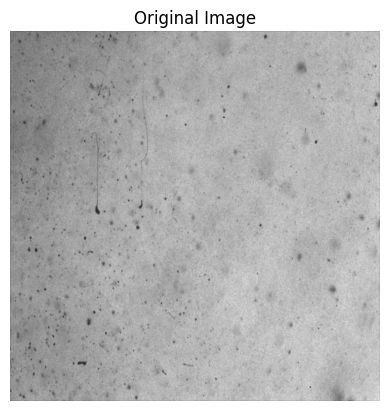

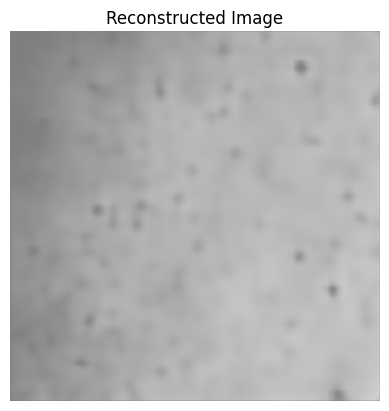

In [8]:
def display_image(tensor, title="Image"):
    img = tensor.cpu().detach().permute(1, 2, 0).numpy()
    img = np.clip(img, 0, 1)  # Ensure values are in [0, 1] range
    plt.imshow(img)
    plt.axis("off")
    plt.title(title)
    plt.show()

display_image(sample_img[0], title="Original Image")
display_image(reconstructed_img[0], title="Reconstructed Image")

Shape of latent space: torch.Size([2, 512, 64, 64])
Shape of reshaped latent space: torch.Size([8192, 512])
Cluster labels grid shape: (2, 64, 64)


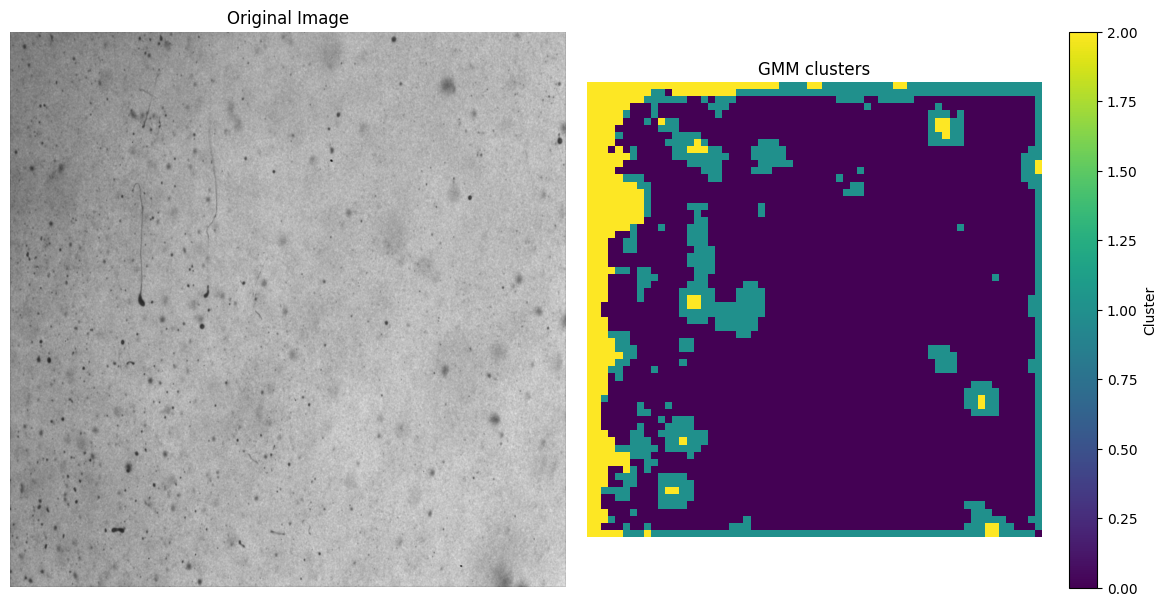

In [14]:
# Step 1: Update Patch Size
patch_size = 8  # Finer spatial granularity

# Step 2: Extract Latent Space Without Flattening Spatial Dimensions
with torch.no_grad():
    latent_space = encoder(sample_img)  # Shape: [B, C, H, W]
    print(f"Shape of latent space: {latent_space.shape}")

# Step 3: Reshape for GMM Clustering
latent_space_reshaped = latent_space.permute(0, 2, 3, 1).reshape(-1, latent_space.shape[1])  # Shape: [N, C]
print(f"Shape of reshaped latent space: {latent_space_reshaped.shape}")

# Step 4: Apply GMM Clustering
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=3, random_state=42, covariance_type="full")
gmm.fit(latent_space_reshaped.cpu().numpy())  # Fit on reshaped latent space
cluster_labels = gmm.predict(latent_space_reshaped.cpu().numpy())  # Shape: [N]

# Step 5: Map Cluster Labels Back to Spatial Grid
grid_cols = latent_space.shape[3]  # 1024 / 8 = 128
grid_rows = latent_space.shape[2]  # 1024 / 8 = 128
cluster_labels_grid = cluster_labels.reshape(latent_space.shape[0], grid_rows, grid_cols)  # Shape: [B, H, W]

print(f"Cluster labels grid shape: {cluster_labels_grid.shape}")

# Step 6: Visualize the Clusters
def visualize_clusters_on_image(image_batch, cluster_labels_grid):
    """
    Visualize clusters directly on the spatial grid of the image.
    
    Args:
        image_batch (torch.Tensor): Batch of images, shape [B, C, H, W].
        cluster_labels_grid (np.ndarray): Cluster labels, shape [B, H, W].
    
    Returns:
        None
    """
    # Select the first image and its cluster labels
    single_image = image_batch[0]  # Shape: [C, H, W]
    single_cluster_labels = cluster_labels_grid[0]  # Shape: [H, W]

    # Visualize the image and clusters
    plt.figure(figsize=(12, 6))

    # Original Image
    plt.subplot(1, 2, 1)
    image_np = single_image.cpu().numpy().transpose(1, 2, 0)  # Convert CHW to HWC
    if image_np.max() > 1.0:
        image_np = image_np / 255.0  # Normalize
    plt.imshow(image_np, cmap="gray")
    plt.title("Original Image")
    plt.axis("off")

    # Cluster Overlay
    plt.subplot(1, 2, 2)
    plt.imshow(single_cluster_labels, cmap="viridis")
    plt.title("GMM clusters")
    plt.colorbar(label="Cluster")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

# Example usage:
visualize_clusters_on_image(sample_img, cluster_labels_grid)

In [78]:
from sklearn.mixture import GaussianMixture

patch_size = 8 

# extract latent space features
with torch.no_grad():
    latent_space = encoder(sample_img)
    print(f"Shape of latent space: {latent_space.shape}")

# reshape the latent space for gmm
latent_space_reshaped = latent_space.permute(0, 2, 3, 1).reshape(-1, latent_space.shape[1])
print(f"Shape of reshaped latent space: {latent_space_reshaped.shape}")

# apply gmm
gmm = GaussianMixture(n_components=3, random_state=42, covariance_type="full")
gmm.fit(latent_space_reshaped.cpu().numpy())
cluster_labels = gmm.predict(latent_space_reshaped.cpu().numpy())

# reshape cluster labels back into a grid corresponding to the sample image shape
grid_cols = latent_space.shape[3]  #width
grid_rows = latent_space.shape[2]  #height
cluster_labels_grid = cluster_labels.reshape(latent_space.shape[0], grid_rows, grid_cols)

print(f"Cluster labels grid shape: {cluster_labels_grid.shape}")

Shape of latent space: torch.Size([2, 512, 64, 64])
Shape of reshaped latent space: torch.Size([8192, 512])
Cluster labels grid shape: (2, 64, 64)


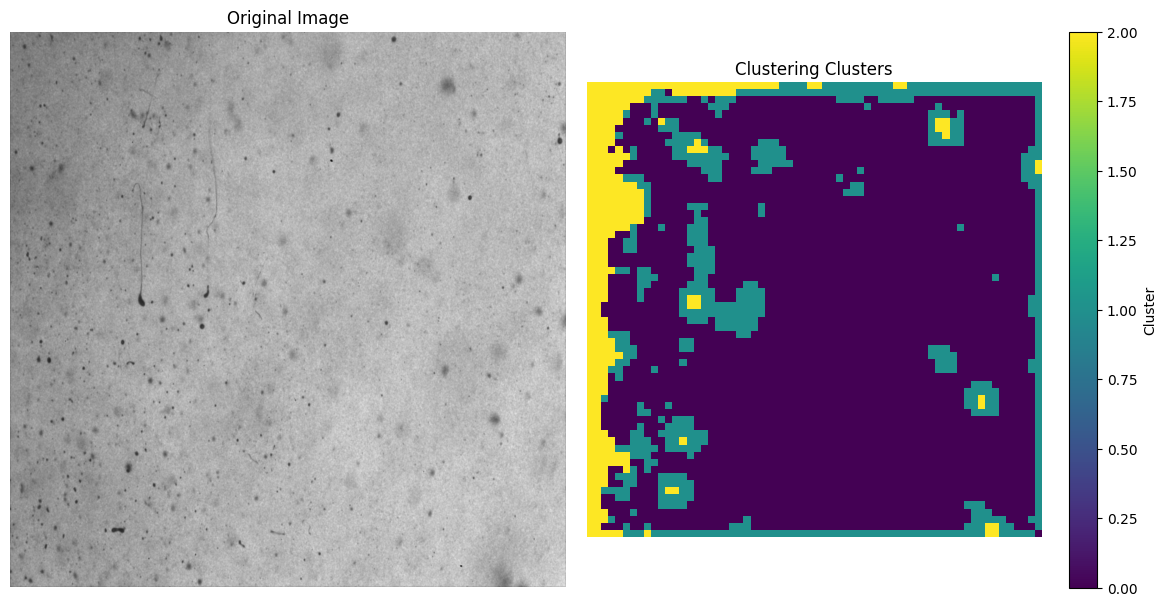

In [79]:
visualize_clusters_on_image(sample_img, cluster_labels_grid)

In [15]:
import matplotlib.pyplot as plt

def visualize_clusters_on_image(image_batch, cluster_labels_grid, method_name="Clustering"):
    """
    Visualize clusters directly on the spatial grid of the image, supporting KMeans, DBSCAN, and GMM.
    
    Args:
        image_batch (torch.Tensor): Batch of images, shape [B, C, H, W].
        cluster_labels_grid (np.ndarray): Cluster labels, shape [B, H, W].
        method_name (str): Name of the clustering method (e.g., 'KMeans', 'DBSCAN', 'GMM').
    
    Returns:
        None (displays the visualization directly).
    """
    # Select the first image and its cluster labels
    single_image = image_batch[0]  # Shape: [C, H, W]
    single_cluster_labels = cluster_labels_grid[0]  # Shape: [H, W]

    # Visualize the image and clusters
    plt.figure(figsize=(12, 6))

    # Original Image
    plt.subplot(1, 2, 1)
    image_np = single_image.cpu().numpy().transpose(1, 2, 0)  # Convert CHW to HWC
    if image_np.max() > 1.0:
        image_np = image_np / 255.0  # Normalize
    plt.imshow(image_np, cmap="gray")
    plt.title("Original Image")
    plt.axis("off")

    # Cluster Overlay
    plt.subplot(1, 2, 2)
    plt.imshow(single_cluster_labels, cmap="viridis")
    plt.title(f"{method_name} Clusters")
    plt.colorbar(label="Cluster")
    plt.axis("off")

    plt.tight_layout()
    plt.show()


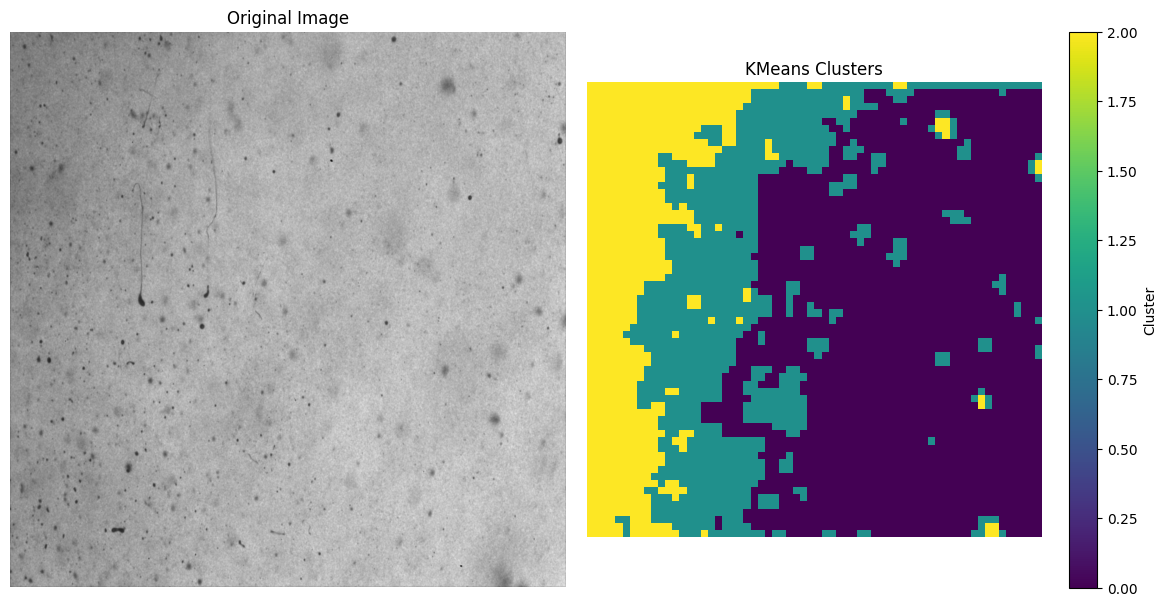

In [16]:
from sklearn.cluster import KMeans

# Step 1: Apply KMeans
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(latent_space_reshaped.cpu().numpy())  # Use the reshaped latent space
cluster_labels = kmeans.labels_  # Shape: [N]

# Step 2: Map Cluster Labels to Spatial Grid
cluster_labels_grid = cluster_labels.reshape(latent_space.shape[0], grid_rows, grid_cols)

# Step 3: Visualize
visualize_clusters_on_image(sample_img, cluster_labels_grid, method_name="KMeans")


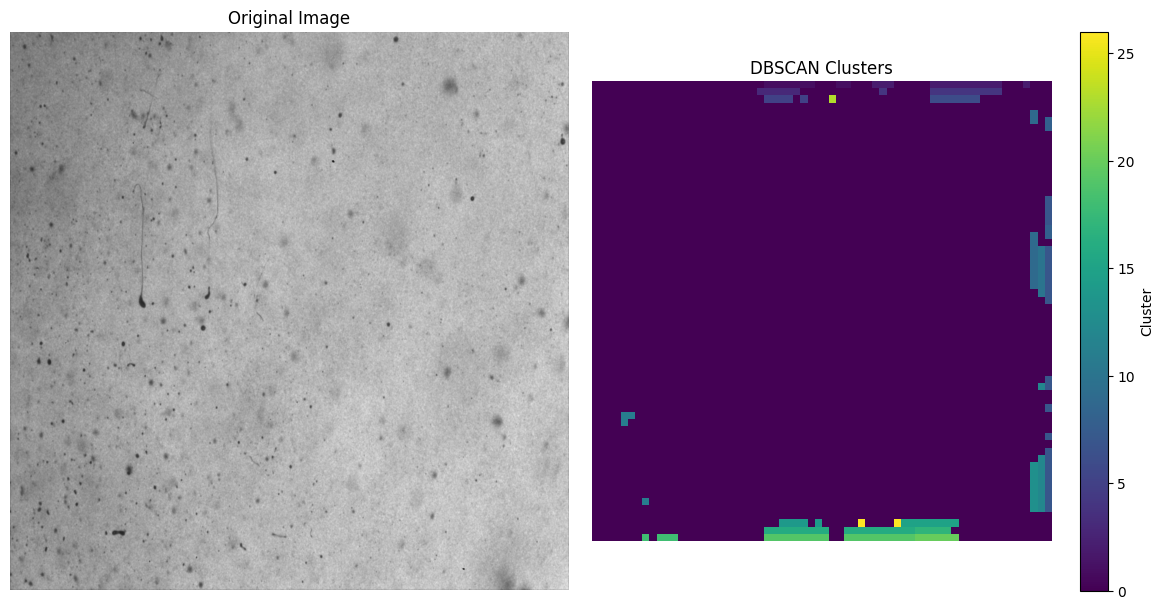

In [28]:
from sklearn.cluster import DBSCAN

# Step 1: Apply DBSCAN
dbscan = DBSCAN(eps=30, min_samples=5)
cluster_labels = dbscan.fit_predict(latent_space_reshaped.cpu().numpy())  # Shape: [N]

# Handle the noise points in DBSCAN (-1 as noise)
cluster_labels[cluster_labels == -1] = 0  # Optionally, treat noise as a separate cluster

# Step 2: Map Cluster Labels to Spatial Grid
cluster_labels_grid = cluster_labels.reshape(latent_space.shape[0], grid_rows, grid_cols)

# Step 3: Visualize
visualize_clusters_on_image(sample_img, cluster_labels_grid, method_name="DBSCAN")


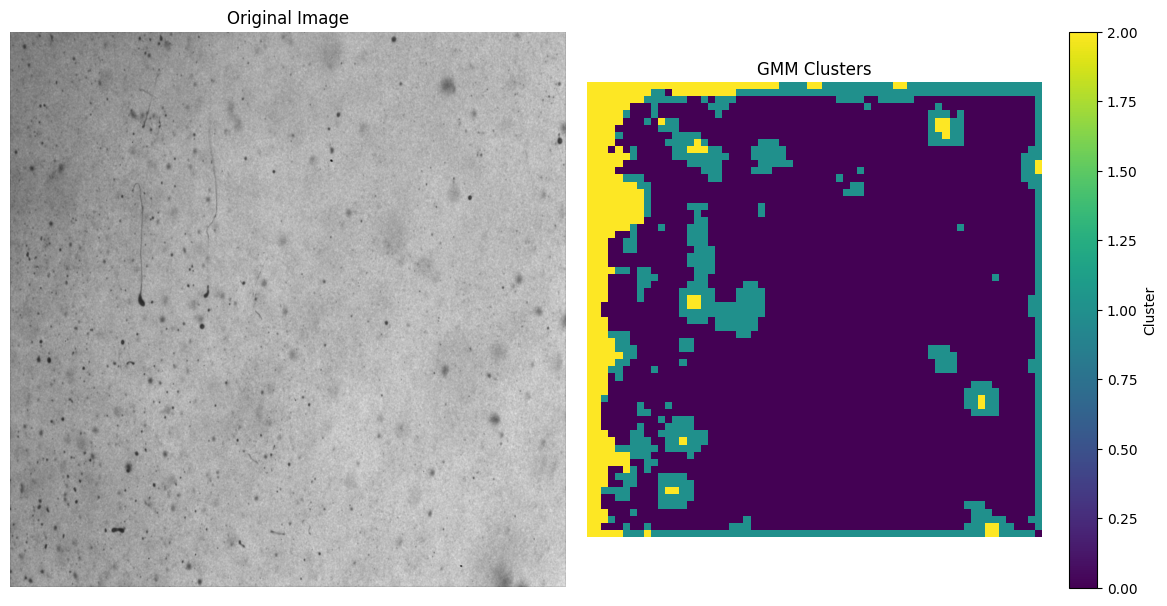

In [18]:
from sklearn.mixture import GaussianMixture

# Step 1: Apply GMM
gmm = GaussianMixture(n_components=3, random_state=42, covariance_type="full")
gmm.fit(latent_space_reshaped.cpu().numpy())
cluster_labels = gmm.predict(latent_space_reshaped.cpu().numpy())  # Shape: [N]

# Step 2: Map Cluster Labels to Spatial Grid
cluster_labels_grid = cluster_labels.reshape(latent_space.shape[0], grid_rows, grid_cols)

# Step 3: Visualize
visualize_clusters_on_image(sample_img, cluster_labels_grid, method_name="GMM")


Nanoparticle Count: {'total_particles': 48, 'cluster_counts': {1: 35, 2: 13}}


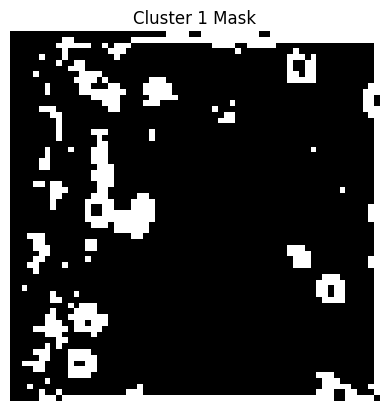

In [19]:
import cv2
import numpy as np

def count_nanoparticles(cluster_labels_grid):
    """
    Count the number of nanoparticles in the cluster map using connected component analysis.
    
    Args:
        cluster_labels_grid (np.ndarray): Cluster labels, shape [B, H, W].
    
    Returns:
        dict: Cluster-wise and total nanoparticle count.
    """
    total_particles = 0
    cluster_counts = {}
    
    # Iterate through each cluster (ignoring the background, if any)
    unique_clusters = np.unique(cluster_labels_grid)
    for cluster_id in unique_clusters:
        if cluster_id == 0:  # Assume 0 is background, skip it
            continue

        # Binary mask for the current cluster
        cluster_mask = (cluster_labels_grid == cluster_id).astype(np.uint8)

        # Perform connected component analysis
        num_labels, labels_im = cv2.connectedComponents(cluster_mask)
        cluster_counts[cluster_id] = num_labels - 1  # Exclude the background label (0)
        total_particles += num_labels - 1

    return {"total_particles": total_particles, "cluster_counts": cluster_counts}


# Example Usage:
cluster_labels_grid_np = cluster_labels_grid[0]  # Select the first image's cluster map
result = count_nanoparticles(cluster_labels_grid_np)
print("Nanoparticle Count:", result)

# Visualize One Cluster for Debugging
selected_cluster_id = 1  # Choose a cluster ID to visualize
cluster_mask = (cluster_labels_grid_np == selected_cluster_id).astype(np.uint8)
plt.imshow(cluster_mask, cmap="gray")
plt.title(f"Cluster {selected_cluster_id} Mask")
plt.axis("off")
plt.show()

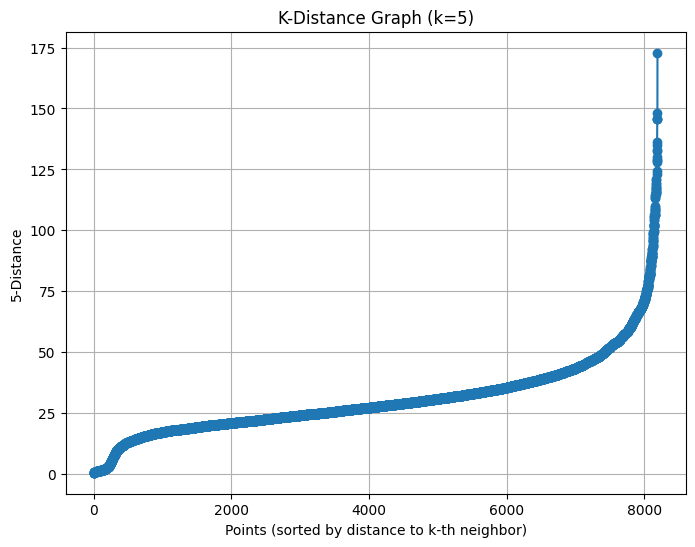

In [24]:
from sklearn.neighbors import NearestNeighbors
import numpy as np
import matplotlib.pyplot as plt

def plot_k_distance(data, k=5):
    """
    Plots the k-distance graph to help select the `eps` parameter for DBSCAN.
    
    Args:
        data (np.ndarray): Data for DBSCAN, shape [N, features].
        k (int): The k-th nearest neighbor to calculate distances for.
    
    Returns:
        None (plots the k-distance graph).
    """
    # Fit Nearest Neighbors model
    nbrs = NearestNeighbors(n_neighbors=k).fit(data)
    
    # Find distances to the k-th nearest neighbor for each point
    distances, _ = nbrs.kneighbors(data)
    
    # Extract the k-th nearest neighbor distances (column `k-1`)
    k_distances = np.sort(distances[:, k-1])  # Sort distances in ascending order
    
    # Plot the sorted k-distances
    plt.figure(figsize=(8, 6))
    plt.plot(k_distances, marker='o')
    plt.title(f"K-Distance Graph (k={k})")
    plt.xlabel("Points (sorted by distance to k-th neighbor)")
    plt.ylabel(f"{k}-Distance")
    plt.grid()
    plt.show()

# Example Usage:
latent_space_np = latent_space_reshaped.cpu().numpy()  # Ensure latent space is in NumPy format
plot_k_distance(latent_space_np, k=5)  # Set k = min_samples - 1


In [43]:
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.cluster import DBSCAN
import numpy as np

from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.cluster import DBSCAN
import numpy as np

def grid_search_dbscan(data, eps_range, min_samples_range):
    """
    Perform grid search for DBSCAN parameters (`eps` and `min_samples`) and evaluate cluster quality.

    Args:
        data (np.ndarray): Data to cluster, shape [N, features].
        eps_range (list): List of `eps` values to test.
        min_samples_range (list): List of `min_samples` values to test.

    Returns:
        dict: Best parameters and scores.
    """
    best_params = None
    best_silhouette = -1
    best_db_score = float("inf")  # Lower Davies-Bouldin score is better

    for eps in eps_range:
        for min_samples in min_samples_range:
            dbscan = DBSCAN(eps=eps, min_samples=min_samples)
            cluster_labels = dbscan.fit_predict(data)

            # Skip configurations where all points are noise or only one cluster is formed
            num_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
            if num_clusters <= 1:
                continue

            try:
                # Compute clustering metrics
                silhouette = silhouette_score(data, cluster_labels, metric="euclidean")
                db_score = davies_bouldin_score(data, cluster_labels)

                print(f"eps={eps:.2f}, min_samples={min_samples}, "
                      f"silhouette={silhouette:.3f}, db_score={db_score:.3f}")

                # Update the best parameters based on silhouette score
                if silhouette > best_silhouette:
                    best_silhouette = silhouette
                    best_db_score = db_score
                    best_params = {"eps": eps, "min_samples": min_samples}

            except ValueError as e:
                # Handle cases where metrics fail (e.g., insufficient clusters)
                print(f"Skipping eps={eps}, min_samples={min_samples} due to error: {e}")
                continue

    return {"best_params": best_params, "best_silhouette": best_silhouette, "best_db_score": best_db_score}


# Example Usage:
eps_range = np.arange(20, 31, 1)  # Fine-tune around the k-distance elbow point
min_samples_range = range(2, 10)  # Test min_samples values between 2 and 10

latent_space_np = latent_space_reshaped.cpu().numpy()  # Convert latent space to NumPy format
print(latent_space_np.shape)
best_dbscan_params = grid_search_dbscan(latent_space_np, eps_range, min_samples_range)

print("Best DBSCAN Parameters:", best_dbscan_params)

(8192, 512)
eps=20.00, min_samples=2, silhouette=-0.496, db_score=1.693
eps=20.00, min_samples=3, silhouette=-0.523, db_score=1.779
eps=20.00, min_samples=4, silhouette=-0.545, db_score=1.609
eps=20.00, min_samples=5, silhouette=-0.534, db_score=1.846
eps=20.00, min_samples=6, silhouette=-0.461, db_score=1.689
eps=20.00, min_samples=7, silhouette=-0.433, db_score=1.832
eps=20.00, min_samples=8, silhouette=-0.426, db_score=1.869
eps=20.00, min_samples=9, silhouette=-0.410, db_score=1.821
eps=21.00, min_samples=2, silhouette=-0.611, db_score=2.062
eps=21.00, min_samples=3, silhouette=-0.647, db_score=2.150
eps=21.00, min_samples=4, silhouette=-0.674, db_score=1.937
eps=21.00, min_samples=5, silhouette=-0.516, db_score=1.848
eps=21.00, min_samples=6, silhouette=-0.500, db_score=1.859
eps=21.00, min_samples=7, silhouette=-0.461, db_score=2.122
eps=21.00, min_samples=8, silhouette=-0.381, db_score=1.981
eps=21.00, min_samples=9, silhouette=-0.469, db_score=2.180
eps=22.00, min_samples=2, si

In [32]:
from sklearn.decomposition import PCA

# Convert PyTorch tensor to NumPy array
latent_space_np = latent_space_reshaped.cpu().numpy()  # Shape: [8192, 512]

# Apply PCA
n_components = 50  # Adjust based on your needs (e.g., explained variance)
pca = PCA(n_components=n_components)
latent_space_pca = pca.fit_transform(latent_space_np)  # Shape: [8192, 50]

print(f"Shape after PCA: {latent_space_pca.shape}")

Shape after PCA: (8192, 50)


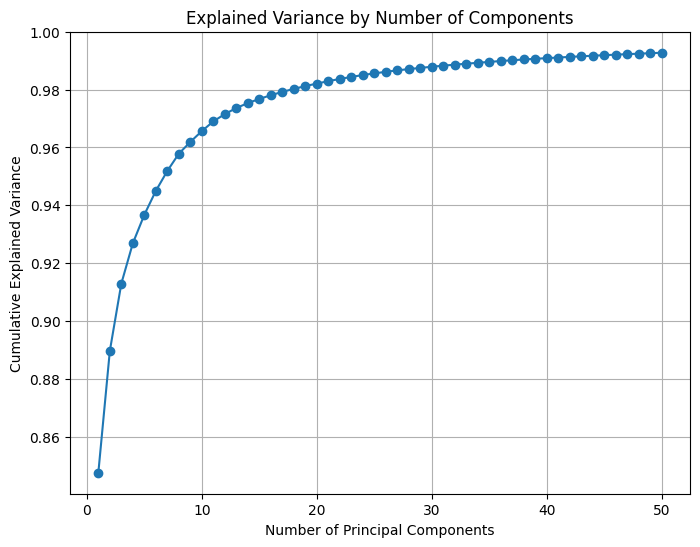

In [35]:
# Plot the explained variance
explained_variance_ratio = np.cumsum(pca.explained_variance_ratio_)
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='o')
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("Explained Variance by Number of Components")
plt.grid()
plt.show()

In [36]:
# Retain 20 components based on explained variance
pca = PCA(n_components=20)
latent_space_pca = pca.fit_transform(latent_space_np)  # Shape: [8192, 20]
print(f"Shape after PCA: {latent_space_pca.shape}")

Shape after PCA: (8192, 20)


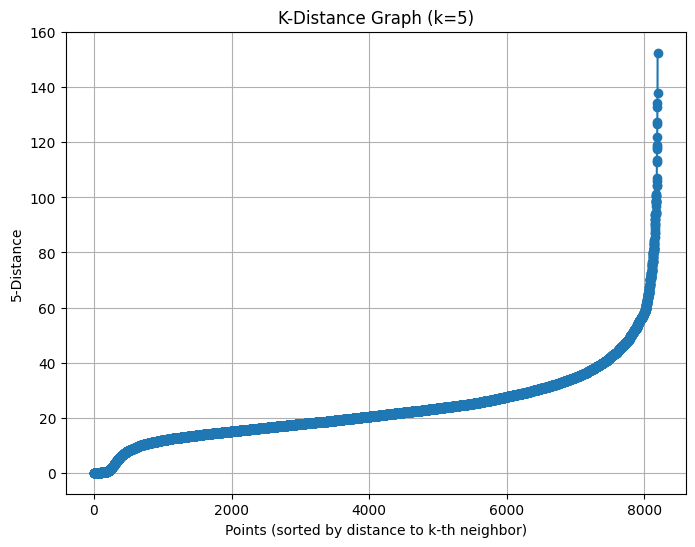

In [37]:
plot_k_distance(latent_space_pca, k=5)

In [45]:
eps_range = np.arange(24, 60, 1)  # range around the elbow
min_samples_range = range(2, 10)  # test values for density clustering

best_dbscan_params = grid_search_dbscan(latent_space_pca, eps_range, min_samples_range)
print("Best DBSCAN Parameters:", best_dbscan_params)

eps=24.00, min_samples=2, silhouette=-0.632, db_score=1.794
eps=24.00, min_samples=3, silhouette=-0.602, db_score=1.756
eps=24.00, min_samples=4, silhouette=-0.565, db_score=1.466
eps=24.00, min_samples=5, silhouette=-0.544, db_score=1.380
eps=24.00, min_samples=6, silhouette=-0.512, db_score=1.277
eps=24.00, min_samples=7, silhouette=-0.433, db_score=1.335
eps=24.00, min_samples=8, silhouette=-0.539, db_score=1.533
eps=24.00, min_samples=9, silhouette=-0.527, db_score=1.711
eps=25.00, min_samples=2, silhouette=-0.617, db_score=1.779
eps=25.00, min_samples=3, silhouette=-0.595, db_score=1.701
eps=25.00, min_samples=4, silhouette=-0.549, db_score=1.541
eps=25.00, min_samples=5, silhouette=-0.541, db_score=1.492
eps=25.00, min_samples=6, silhouette=-0.547, db_score=1.360
eps=25.00, min_samples=7, silhouette=-0.360, db_score=1.192
eps=25.00, min_samples=8, silhouette=-0.405, db_score=1.272
eps=25.00, min_samples=9, silhouette=-0.507, db_score=1.488
eps=26.00, min_samples=2, silhouette=-0.

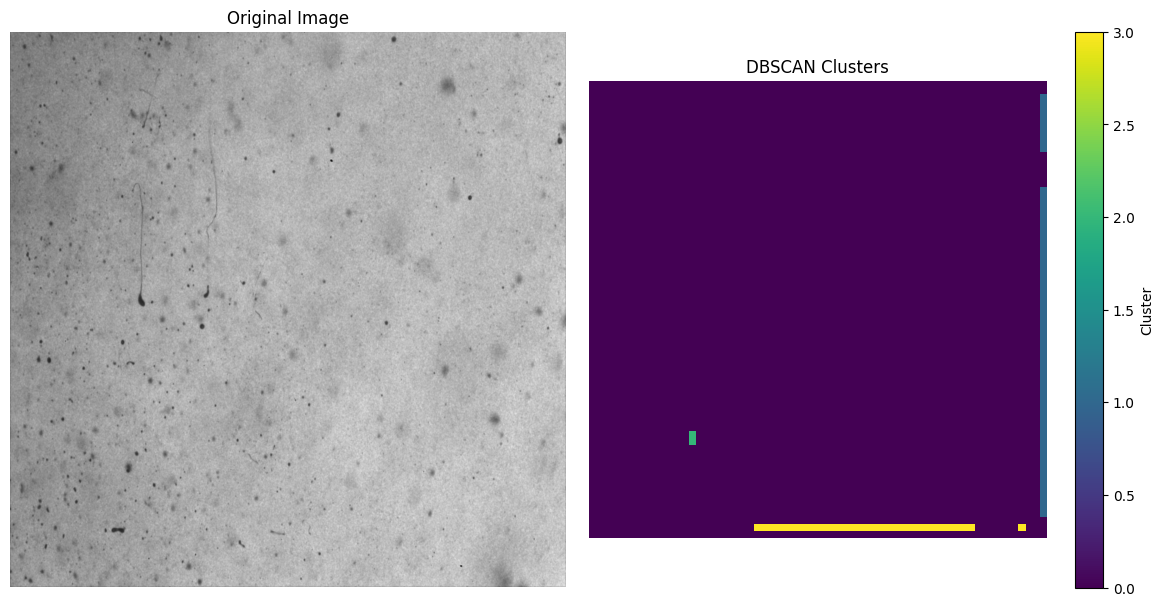

In [46]:
# Step 1: Apply DBSCAN
dbscan = DBSCAN(eps=59, min_samples=4)
cluster_labels = dbscan.fit_predict(latent_space_reshaped.cpu().numpy())  # Shape: [N]

# Handle the noise points in DBSCAN (-1 as noise)
cluster_labels[cluster_labels == -1] = 0  # Optionally, treat noise as a separate cluster

# Step 2: Map Cluster Labels to Spatial Grid
cluster_labels_grid = cluster_labels.reshape(latent_space.shape[0], grid_rows, grid_cols)

# Step 3: Visualize
visualize_clusters_on_image(sample_img, cluster_labels_grid, method_name="DBSCAN")

In [47]:
print("Number of clusters:", len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0))
print("Number of noise points:", list(cluster_labels).count(-1))

Number of clusters: 5
Number of noise points: 0


In [48]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.cluster import DBSCAN

def grid_search_dbscan(data, eps_range, min_samples_range):
    """
    Perform grid search for DBSCAN parameters (`eps` and `min_samples`) and evaluate cluster quality.

    Args:
        data (np.ndarray): Data to cluster, shape [N, features].
        eps_range (list): List of `eps` values to test.
        min_samples_range (list): List of `min_samples` values to test.

    Returns:
        dict: Best parameters and scores.
        pd.DataFrame: Results with parameters and metrics.
    """
    best_params = None
    best_silhouette = -1
    best_db_score = float("inf")  # Lower Davies-Bouldin score is better

    # Store results for each combination
    results = []

    for eps in eps_range:
        for min_samples in min_samples_range:
            dbscan = DBSCAN(eps=eps, min_samples=min_samples)
            cluster_labels = dbscan.fit_predict(data)

            # Skip configurations where all points are noise or only one cluster is formed
            num_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
            if num_clusters <= 1:
                results.append({
                    "eps": eps,
                    "min_samples": min_samples,
                    "silhouette": None,
                    "db_score": None,
                    "num_clusters": num_clusters
                })
                continue

            try:
                # Compute clustering metrics
                silhouette = silhouette_score(data, cluster_labels, metric="euclidean")
                db_score = davies_bouldin_score(data, cluster_labels)

                print(f"eps={eps:.2f}, min_samples={min_samples}, "
                      f"silhouette={silhouette:.3f}, db_score={db_score:.3f}")

                # Save result
                results.append({
                    "eps": eps,
                    "min_samples": min_samples,
                    "silhouette": silhouette,
                    "db_score": db_score,
                    "num_clusters": num_clusters
                })

                # Update the best parameters based on silhouette score
                if silhouette > best_silhouette:
                    best_silhouette = silhouette
                    best_db_score = db_score
                    best_params = {"eps": eps, "min_samples": min_samples}

            except ValueError as e:
                # Handle cases where metrics fail (e.g., insufficient clusters)
                print(f"Skipping eps={eps}, min_samples={min_samples} due to error: {e}")
                results.append({
                    "eps": eps,
                    "min_samples": min_samples,
                    "silhouette": None,
                    "db_score": None,
                    "num_clusters": num_clusters
                })
                continue

    # Convert results to DataFrame for easier analysis
    results_df = pd.DataFrame(results)

    return {"best_params": best_params, "best_silhouette": best_silhouette, "best_db_score": best_db_score}, results_df


eps=20.00, min_samples=2, silhouette=-0.650, db_score=1.999
eps=20.00, min_samples=3, silhouette=-0.661, db_score=1.890
eps=20.00, min_samples=4, silhouette=-0.666, db_score=1.865
eps=20.00, min_samples=5, silhouette=-0.657, db_score=1.899
eps=20.00, min_samples=6, silhouette=-0.609, db_score=1.941
eps=20.00, min_samples=7, silhouette=-0.520, db_score=1.963
eps=20.00, min_samples=8, silhouette=-0.490, db_score=1.885
eps=20.00, min_samples=9, silhouette=-0.274, db_score=2.206
eps=25.00, min_samples=2, silhouette=-0.617, db_score=1.779
eps=25.00, min_samples=3, silhouette=-0.595, db_score=1.701
eps=25.00, min_samples=4, silhouette=-0.549, db_score=1.541
eps=25.00, min_samples=5, silhouette=-0.541, db_score=1.492
eps=25.00, min_samples=6, silhouette=-0.547, db_score=1.360
eps=25.00, min_samples=7, silhouette=-0.360, db_score=1.192
eps=25.00, min_samples=8, silhouette=-0.405, db_score=1.272
eps=25.00, min_samples=9, silhouette=-0.507, db_score=1.488
eps=30.00, min_samples=2, silhouette=-0.

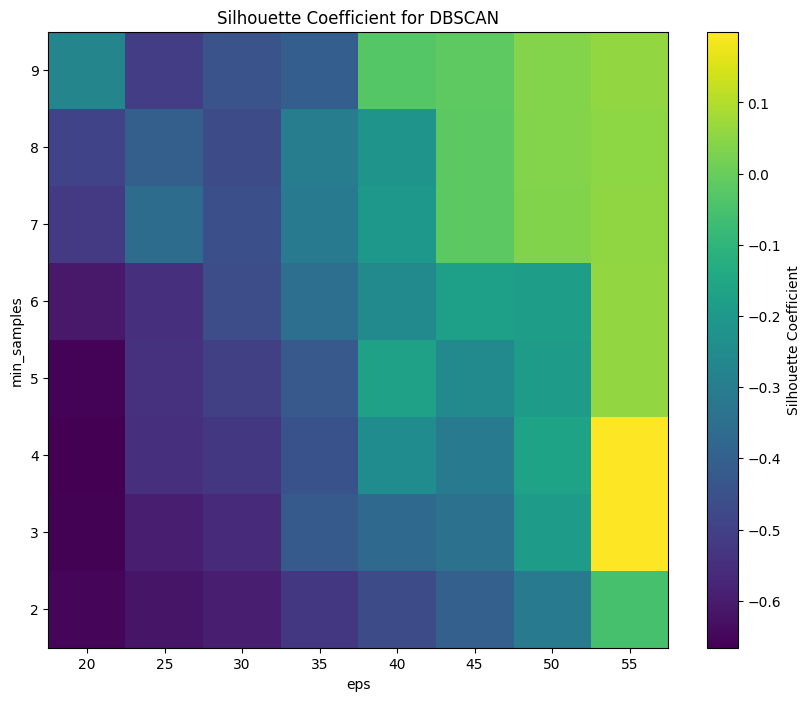

In [50]:
# Run grid search
eps_range = np.arange(20, 60, 5)
min_samples_range = range(2, 10)

best_params, results_df = grid_search_dbscan(latent_space_pca, eps_range, min_samples_range)

# Drop rows where silhouette is None
results_df = results_df.dropna(subset=["silhouette"])

# Pivot table for plotting
pivot_table = results_df.pivot(index="min_samples", columns="eps", values="silhouette")

# Plot heatmap
plt.figure(figsize=(10, 8))
plt.imshow(pivot_table, cmap="viridis", origin="lower", aspect="auto")
plt.colorbar(label="Silhouette Coefficient")
plt.xticks(ticks=np.arange(len(pivot_table.columns)), labels=pivot_table.columns)
plt.yticks(ticks=np.arange(len(pivot_table.index)), labels=pivot_table.index)
plt.xlabel("eps")
plt.ylabel("min_samples")
plt.title("Silhouette Coefficient for DBSCAN")
plt.show()


In [60]:
from collections import Counter
cluster_counts = Counter(cluster_labels)
if -1 in cluster_counts:  # Remove noise count
    del cluster_counts[-1]

# Sort clusters by size
sorted_clusters = sorted(cluster_counts.items(), key=lambda x: x[1], reverse=True)

# Display each cluster and its size
for cluster_id, n_i in sorted_clusters:
    print(f"Cluster {cluster_id}: {n_i} points")

Cluster 0: 8027 points
Cluster 1: 114 points
Cluster 3: 44 points
Cluster 2: 4 points
Cluster 4: 3 points


In [61]:
meaningful_clusters = set(cluster_labels) - {0, -1}  # Exclude Cluster 0 and noise
print(f"Number of meaningful clusters: {len(meaningful_clusters)}")


Number of meaningful clusters: 4


In [62]:
# Count points in each cluster
from collections import Counter

cluster_counts = Counter(cluster_labels)

# Exclude Cluster 0 and noise (-1 if present)
if 0 in cluster_counts:
    del cluster_counts[0]  # Remove Cluster 0
if -1 in cluster_counts:
    del cluster_counts[-1]  # Remove noise if present

# Sum the points in the remaining clusters
meaningful_ni = sum(cluster_counts.values())
print(f"Total points in meaningful clusters: {meaningful_ni}")

Total points in meaningful clusters: 165


In [63]:
from collections import Counter

# Count points in each cluster
cluster_counts = Counter(cluster_labels)

# Exclude Cluster 0 and noise (-1 if present)
if 0 in cluster_counts:
    del cluster_counts[0]  # Remove Cluster 0
if -1 in cluster_counts:
    del cluster_counts[-1]  # Remove noise if present

# Prepare data for the plot
sorted_clusters = sorted(cluster_counts.items(), key=lambda x: x[1], reverse=True)
cluster_ids = [cluster[0] for cluster in sorted_clusters]
cluster_sizes = [cluster[1] for cluster in sorted_clusters]  # x-axis: ni
cluster_silhouettes = []  # y-axis

for cluster_id in cluster_ids:
    # Calculate average silhouette score for each cluster
    cluster_points = latent_space_pca[cluster_labels == cluster_id]
    cluster_silhouette = silhouette_score(
        latent_space_pca, cluster_labels, metric="euclidean"
    )
    cluster_silhouettes.append(cluster_silhouette)


In [65]:
from sklearn.metrics import silhouette_samples

# Compute silhouette coefficient for each point
silhouette_values = silhouette_samples(latent_space_pca, cluster_labels, metric="euclidean")

In [66]:
from collections import defaultdict

# Dictionary to store average silhouette scores for each cluster
cluster_silhouette_scores = defaultdict(float)

# Exclude Cluster 0 and noise
meaningful_clusters = [label for label in set(cluster_labels) if label > 0]

for cluster_id in meaningful_clusters:
    # Get silhouette scores for points in the current cluster
    cluster_points = (cluster_labels == cluster_id)
    cluster_silhouette_scores[cluster_id] = silhouette_values[cluster_points].mean()


In [67]:
# Get cluster sizes and silhouette scores
cluster_sizes = [cluster_counts[cluster_id] for cluster_id in meaningful_clusters]
cluster_silhouettes = [cluster_silhouette_scores[cluster_id] for cluster_id in meaningful_clusters]


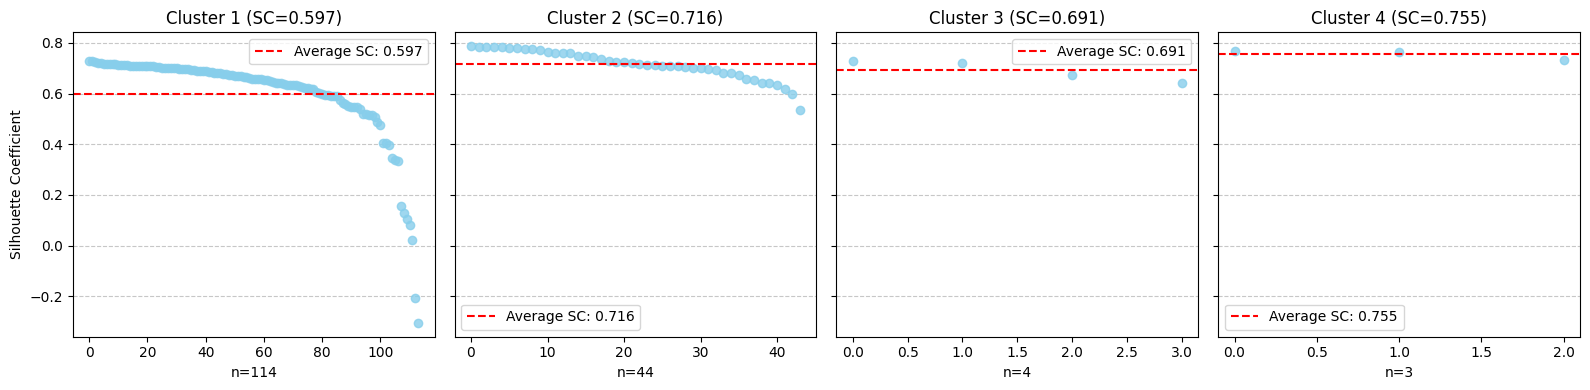

In [77]:
# Set up subplots: 1 row, 4 columns
fig, axes = plt.subplots(1, len(sorted_clusters), figsize=(16, 4), sharey=True)

# Iterate through each cluster and plot on respective subplot
for idx, (cluster_id, n_i) in enumerate(sorted_clusters):
    # Filter silhouette coefficients for the current cluster
    cluster_silhouette_vals = [silhouette_vals[i] for i, label in enumerate(cluster_labels) if label == cluster_id]
    
    # Sort the silhouette values
    cluster_silhouette_vals = sorted(cluster_silhouette_vals, reverse=True)
    
    # Plot on the corresponding axis
    ax = axes[idx]
    ax.plot(
        range(len(cluster_silhouette_vals)),
        cluster_silhouette_vals,
        marker="o",
        linestyle="None",
        color="skyblue",
        alpha=0.8
    )
    
    # Add average silhouette score as a red dashed line
    average_score = np.mean(cluster_silhouette_vals)
    ax.axhline(y=average_score, color="red", linestyle="--", label=f"Average SC: {average_score:.3f}")
    
    # Update title to have "Cluster X (SC=X.XXX)"
    ax.set_title(f"Cluster {idx + 1} (SC={average_score:.3f})")
    ax.set_xlabel(f"n={n_i}")  # x-axis label is the size of the cluster
    if idx == 0:  # Add y-axis label only for the first subplot
        ax.set_ylabel("Silhouette Coefficient")
    ax.legend(loc="best")
    ax.grid(axis="y", linestyle="--", alpha=0.7)

# Adjust layout
plt.tight_layout()
plt.show()
